In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm

import mltools.utils.cuda_tools as cuda_tools
device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import importlib
importlib.reload(utils)

memory_available [73637]
best GPU: 0


<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/notebooks/../utils.py'>

In [2]:
os.chdir('/n/home12/cfpark00/ML/ToyCompDiff')

In [57]:
#os.chdir('/n/home12/cfpark00/ML/vectorCG')
plot_datas=[]
acc_sigma=5
ignore_nuisance=True
det_model=False#True
#for fol in glob.glob("./data/base/seed*"):
#for fol in glob.glob("./data/data_noise/dn=1e-05_seed*"):
#for fol in glob.glob("./data/det/seed*"):
#for fol in glob.glob("./data/dim=4/seed*"):
#for fol in glob.glob("./data/h64/base/seed*"):
for fol in glob.glob("./data/init_scales/inis=0.3*"):
#for fol in glob.glob("./data/nuisance/dn=3_seed*"):
#for fol in glob.glob("./data/nuisance_det/dn=5_seed*"):
#for fol in glob.glob("./data/perdim=3/seed*"):
#for fol in glob.glob("./data/perdim=5/seed*"):
#for fol in glob.glob("./data/perdim=6/seed*"):
#for fol in glob.glob("./data/perdim=4_dim=4/seed*"):
    config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_file)
    logs_file=os.path.join(fol,"logs.pth")
    logs=torch.load(logs_file)

    x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)
    n_classes=len(config["means"])
    #losses
    loss_keys=["elbo","diffusion_loss","latent_loss","reconstruction_loss"]
    if det_model:
        losses_perclass={l:[] for l in range(n_classes)}
    else:
        loss_keys=["elbo","diffusion_loss","latent_loss","reconstruction_loss"]
        losses_perclass={l:dict(zip(loss_keys,[[] for _ in range(len(loss_keys))])) for l in range(n_classes)}
    ckpts=[]
    gens_tr=[]
    gens_te=[]
    model=utils.get_model(config)
    for ckpt_path in tqdm.tqdm(logs["ckpt_paths"]):
        if "h64" in fol:
            print("For h64, changing ckpt path")
            ckpt_path=ckpt_path.replace("/base/","/h64/base/")
        ckpt=torch.load(ckpt_path)
        if not det_model:
            for key in list(ckpt.keys()):
                if key[:4]=="net.":
                    del ckpt[key]
        ckpts.append(ckpt)
        model.load_state_dict(ckpt)
        model=model.to(device)
        x_tr_torch=torch.tensor(x_tr).to(device=device,dtype=torch.float32)
        y_tr_torch=torch.tensor(y_tr).to(device=device,dtype=torch.float32)
        x_te_torch=torch.tensor(x_te).to(device=device,dtype=torch.float32)
        y_te_torch=torch.tensor(y_te).to(device=device,dtype=torch.float32)
        ##loss
        with torch.no_grad():
            if det_model:
                loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none").mean(-1)
                loss_te=model.get_loss(x=x_te_torch,c=y_te_torch,reduction="none").mean(-1)
            else:
                loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none")[1]#decomposed loss
                loss_te=model.get_loss(x=x_te_torch,c=y_te_torch,reduction="none")[1]#decomposed loss
        if det_model:
            for l in range(n_classes):
                in_tr=np.any(l_tr==l)
                if in_tr:
                    losses_perclass[l].append(loss_tr[l_tr==l].cpu().numpy())
                else:
                    losses_perclass[l].append(loss_te[l_te==l].cpu().numpy())
        else:
            for loss_key in loss_keys:
                for l in range(n_classes):
                    in_tr=np.any(l_tr==l)
                    if in_tr:
                        losses_perclass[l][loss_key].append(loss_tr[loss_key][l_tr==l].cpu().numpy())
                    else:
                        losses_perclass[l][loss_key].append(loss_te[loss_key][l_te==l].cpu().numpy())
        ##
        with torch.no_grad():
            gen_tr=model.generate(y_tr_torch).detach().cpu().numpy()
            gen_te=model.generate(y_te_torch).detach().cpu().numpy()
        gens_tr.append(gen_tr)
        gens_te.append(gen_te)
    if det_model:
        for l in range(n_classes):
            losses_perclass[l]=np.stack(losses_perclass[l],axis=0)
    else:
        for l in range(n_classes):
            for loss_key in loss_keys:
                losses_perclass[l][loss_key]=np.stack(losses_perclass[l][loss_key],axis=0)

    gens_tr=np.stack(gens_tr,axis=0)
    gens_te=np.stack(gens_te,axis=0)

    save_steps=logs["save_steps"]
    losses=np.array(logs["losses"])
    val_losses=np.array(logs["val_losses"])
    te_losses=np.array(logs["te_losses"])

    means=np.array(config["means"])
    covs=np.array(config["covs"])
    if not ignore_nuisance:
        if "dim_nuisance" in config:
            if "nl_nuisance" in config and config["nl_nuisance"]:
                assert False
            else:
                n,d,dn=means.shape[0],means.shape[1],config["dim_nuisance"]
                nuisance_scale=config.get("nuisance_scale",1.0)
                means=np.concatenate([means,np.zeros((n,dn))],axis=1)
                nuisance_cov=(np.eye(dn)*nuisance_scale**2)[None,:,:].repeat(n,axis=0)
                covs_=np.zeros((n,d+dn,d+dn))
                covs_[:,:d,:d]=covs
                covs_[:,d:,d:]=nuisance_cov
                covs=covs_
                dim=d+dn
        invcovs=np.stack([np.linalg.inv(cov) for cov in covs],axis=0)
        means_sqdist_tr=np.power( (gens_tr-means[l_tr]).mean(1),2 ).mean(1)
        means_sqdist_te=np.power( (gens_te-means[l_te]).mean(1),2 ).mean(1)
    else:
        dim=means.shape[1]
        invcovs=np.stack([np.linalg.inv(cov) for cov in covs],axis=0)
        means_sqdist_tr=np.power( (gens_tr[:,:,:dim]-means[l_tr]).mean(1),2 ).mean(1)
        means_sqdist_te=np.power( (gens_te[:,:,:dim]-means[l_te]).mean(1),2 ).mean(1)

    means_sqdist_perclass={}
    for l in range(n_classes):
        in_tr=np.any(l_tr==l)
        if in_tr:
            means_sqdist_perclass[l]=np.power( (gens_tr[:,l_tr==l,:dim]-means[l]).mean(1),2 ).mean(1)
        else:
            means_sqdist_perclass[l]=np.power( (gens_te[:,l_te==l,:dim]-means[l]).mean(1),2 ).mean(1)

    dev_tr=gens_tr[:,:,:dim]-means[l_tr]
    dev_te=gens_te[:,:,:dim]-means[l_te]
    z_tr=np.einsum("tbi,bij,tbj->tb",dev_tr,invcovs[l_tr],dev_tr)/means.shape[-1]
    z_te=np.einsum("tbi,bij,tbj->tb",dev_te,invcovs[l_te],dev_te)/means.shape[-1]
    accs_tr=(z_tr<acc_sigma).astype(np.float32).mean(-1)
    accs_te=(z_te<acc_sigma).astype(np.float32).mean(-1)
    accs_perclass={}
    for l in range(n_classes):
        in_tr=np.any(l_tr==l)
        if in_tr:
            accs_perclass[l]=(z_tr[:,l_tr==l]<acc_sigma).astype(np.float32).mean(-1)
        else:
            accs_perclass[l]=(z_te[:,l_te==l]<acc_sigma).astype(np.float32).mean(-1)

    plot_data={}
    plot_data["gens_tr"]=gens_tr
    plot_data["gens_te"]=gens_te
    plot_data["min_vlb"]=model.get_min_vlb() if hasattr(model,"get_min_vlb") else 0
    plot_data["save_steps"]=save_steps
    plot_data["losses"]=losses
    plot_data["val_losses"]=val_losses
    plot_data["te_losses"]=te_losses
    plot_data["means_sqdist_tr"]=means_sqdist_tr
    plot_data["means_sqdist_te"]=means_sqdist_te
    plot_data["means_sqdist_perclass"]=means_sqdist_perclass
    plot_data["losses_perclass"]=losses_perclass
    plot_data["accs_perclass"]=accs_perclass
    plot_data["accs_tr"]=accs_tr
    plot_data["accs_te"]=accs_te
    plot_data["ckpts"]=ckpts
    plot_datas.append(plot_data)

100%|██████████| 60/60 [00:04<00:00, 12.21it/s]


In [58]:
tri=np.nonzero(config["n_samples_train"])[0]
means=np.array(config["means"])
md_from_orig=means.sum(1)
in_hull=md_from_orig<=(1.+1e-5)
out_of_hull=md_from_orig>(1.+1e-5)
i_in_hull=np.nonzero(in_hull)[0]
i_out_of_hull=np.nonzero(out_of_hull)[0]
i_in_hull=np.array(list(set(list(i_in_hull))-set(list(tri))))
len(tri),len(i_out_of_hull),len(i_in_hull)

(7, 6, 3)

In [59]:
tri_accs=[]
inh_accs=[]
ooh_accs=[]
for i,plot_data in enumerate(plot_datas):
    save_steps=plot_data["save_steps"]

    tri_accs_=[]
    for i in tri:
        acc=plot_data["accs_perclass"][i]
        tri_accs_.append(acc)
    tri_accs.append(np.array(tri_accs_).mean(0))

    inh_accs_=[]
    for i in i_in_hull:
        acc=plot_data["accs_perclass"][i]
        inh_accs_.append(acc)
    inh_accs.append(np.array(inh_accs_).mean(0))

    ooh_accs_=[]
    for i in i_out_of_hull:
        acc=plot_data["accs_perclass"][i]
        ooh_accs_.append(acc)
    ooh_accs.append(np.array(ooh_accs_).mean(0))

triaccm=np.array(tri_accs).mean(0)
inhaccm=np.array(inh_accs).mean(0)
oohaccm=np.array(ooh_accs).mean(0)

In [60]:
ckpts=plot_datas[0]["ckpts"]
ckpt_keys=ckpts[0].keys()
tckpt={}
for key in ckpt_keys:
    if "model.score_model" not in key:
        continue
    key_=key.replace("model.score_model.","")
    tckpt[key_]=[]
    for ckpt in ckpts:
        tckpt[key_].append(ckpt[key])  
    tckpt[key_]=torch.stack(tckpt[key_],axis=0).cpu().numpy()
    print(key_,tckpt[key_].shape)

embed_t_conditioning.0.weight (60, 256, 64)
embed_t_conditioning.0.bias (60, 256)
embed_t_conditioning.2.weight (60, 256, 256)
embed_t_conditioning.2.bias (60, 256)
embedders.0.0.0.weight (60, 1024, 256)
embedders.0.0.0.bias (60, 1024)
embedders.0.0.2.weight (60, 1024, 1024)
embedders.0.0.2.bias (60, 1024)
embedders.0.1.0.weight (60, 1024, 2)
embedders.0.1.0.bias (60, 1024)
embedders.0.1.2.weight (60, 1024, 1024)
embedders.0.1.2.bias (60, 1024)
layers.0.weight (60, 1024, 2)
layers.0.bias (60, 1024)
layers.1.weight (60, 2, 1024)
layers.1.bias (60, 2)


In [61]:
tckpt['embedders.0.1.2.weight'].shape

(60, 1024, 1024)

In [62]:
eigvs=np.linalg.eigvals(tckpt['embedders.0.1.2.weight'])
eigvs.shape

(60, 1024)

In [63]:
eigvs_abs=np.abs(eigvs)**2

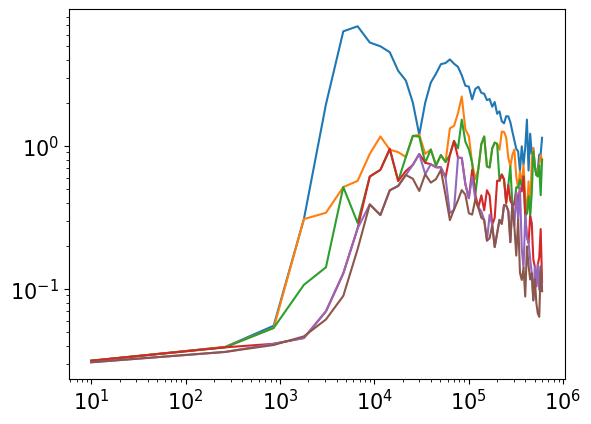

In [64]:
plt.plot(save_steps,eigvs_abs[:,0])
plt.plot(save_steps,eigvs_abs[:,1])
plt.plot(save_steps,eigvs_abs[:,2])
plt.plot(save_steps,eigvs_abs[:,3])
plt.plot(save_steps,eigvs_abs[:,4])
plt.plot(save_steps,eigvs_abs[:,5])
plt.xscale("log")
plt.yscale("log")

In [65]:
def mMn(vals):
    m=vals.min()
    M=vals.max()
    return (vals-m)/(M-m)

Text(0, 0.5, 'Eigenvalue')

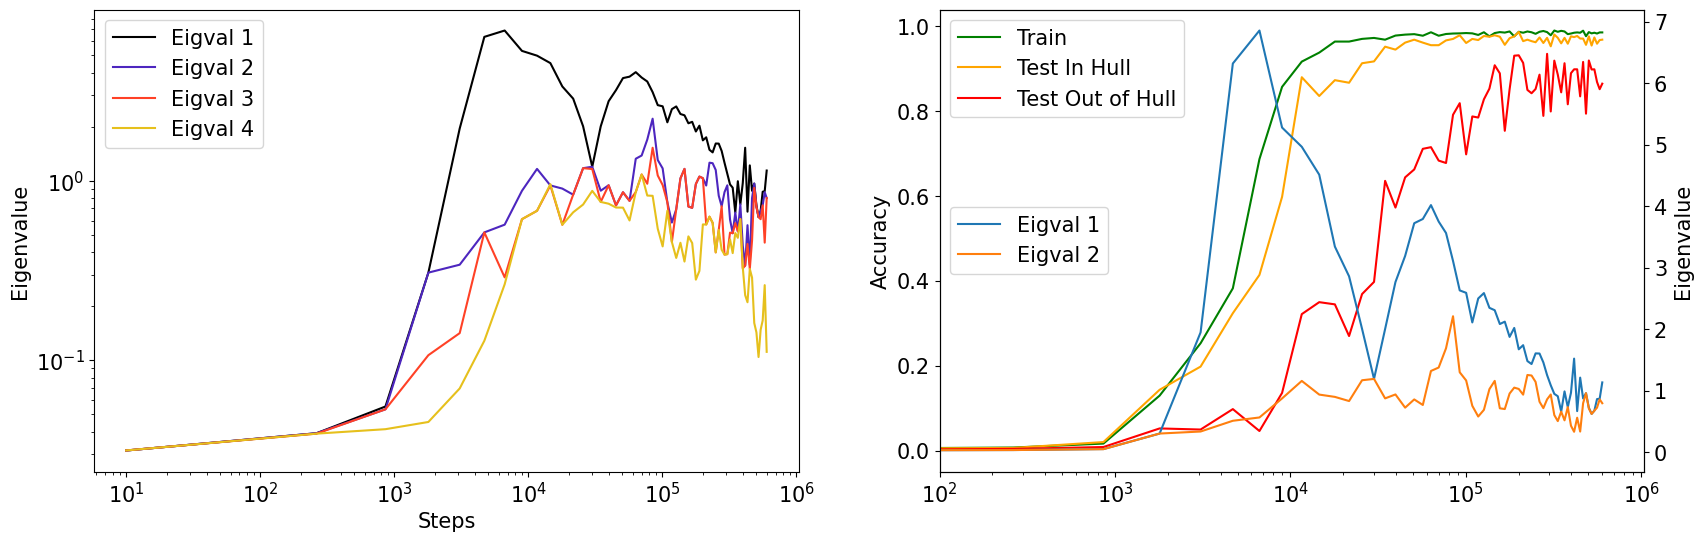

In [66]:
x_left=100
plt.figure(figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.subplot(1,2,1)
cmap=plt.get_cmap("CMRmap")
for i in range(4):
    plt.plot(save_steps,eigvs_abs[:,i],color=cmap(i/4),label="Eigval "+str(i+1))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
plt.legend()

plt.subplot(1,2,2)
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
plt.xscale("log")
plt.legend()
plt.xlim(left=x_left)
plt.ylabel("Accuracy")
plt.twinx()
plt.plot(save_steps,eigvs_abs[:,0],label="Eigval 1")
plt.plot(save_steps,eigvs_abs[:,1],label="Eigval 2")
plt.legend(loc="center left")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
#plt.savefig("./figures/eigen_predict.png")

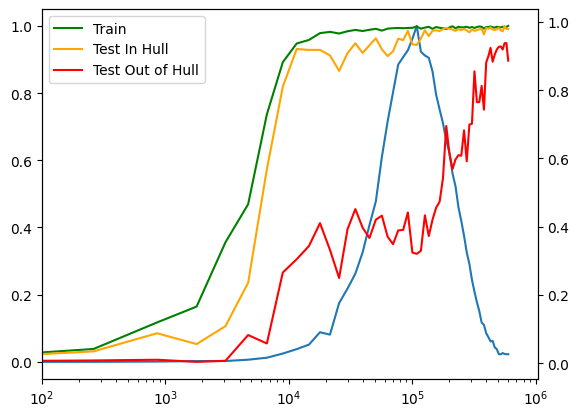

In [20]:
x_left=100
min_vlb=plot_data["min_vlb"]
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.weight'][:,:,0],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.bias'][:,:],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.2.bias'][:,:],axis=1))
plt.plot(save_steps,mMn(eigvs_abs[:,0]),label="Max. Eigval. of Cond. Proj.")
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.weight'][:,:,0],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.bias'],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.1.bias'],axis=1)))
plt.xscale("log")
plt.xlim(left=x_left)
#plt.twinx()
#plt.plot(save_steps,val_losses-min_vlb,c="green",alpha=0.5)
#plt.plot(save_steps,te_losses-min_vlb,c="red",alpha=0.5)
#plt.yscale("log")
plt.twinx()
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
#plt.plot(save_steps,acctr_m,c="green",ls="--")
#plt.plot(save_steps,accte_m,c="red",ls="--")
plt.legend()
